<a href="https://colab.research.google.com/github/Pavionio/Fear_and_Hate_in_Taxi/blob/main/anomaly_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import random
import geopy.distance as gp
import plotly.express as px
import math
import geopandas as gpd
from shapely.geometry import Point
import shapely
import json
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from prophet import Prophet
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error

In [3]:

from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
trip_duration = pd.read_csv('/content/gdrive/MyDrive/intensive/Project/nyc_taxi_trip_duration.csv')
weather = pd.read_csv('/content/gdrive/MyDrive/intensive/Project/nyc_2016_weather.csv')

In [ ]:
!unzip -q /content/gdrive/My\ Drive/intensive/Project/trips_2015-2016.zip

In [12]:
trip_duration = pd.read_csv('/content/yellow_tripdata_2016-03.csv')

In [ ]:
trip_duration

In [13]:
trip_duration['distance'] = trip_duration.trip_distance
trip_duration['pickup_datetime'] = trip_duration.tpep_pickup_datetime	

In [9]:
def geo_anomalies(data : pd.DataFrame) -> None :
    
    
    df_for_pickup = pd.read_csv('/content/gdrive/MyDrive/intensive/Project/taxi_zones.csv')  
    df_for_dropoff = pd.read_csv('/content/gdrive/MyDrive/intensive/Project/taxi_zones.csv')  #update with the great help of Pavel Fadeev

    polygon_for_pickup = gpd.GeoDataFrame(geometry=shapely.wkt.loads(df_for_pickup.the_geom))
    #polygon_for_dropoff = gpd.GeoDataFrame(geometry=shapely.wkt.loads(df_for_dropoff.the_geom))

    ls=[]

    for _,row in trip_duration.iterrows():
        ls.append(polygon_for_pickup.contains(Point(row['pickup_longitude'],row['pickup_latitude'])).any() and polygon_for_pickup.contains(Point(row['dropoff_longitude'],row['dropoff_latitude'])).any())

    
    pickup_longitude = trip_duration[['id', 'pickup_longitude']].rename(columns={'pickup_longitude': 'longitude'})
    pickup_longitude['type'] = 'pickup'
    dropoff_longitude = trip_duration[['id', 'dropoff_longitude']].rename(columns={'dropoff_longitude': 'longitude'})
    dropoff_longitude['type'] = 'dropoff'

    longitudes = pd.concat((pickup_longitude, dropoff_longitude))

    pickup_latitude = trip_duration[['id', 'pickup_latitude']].rename(columns={'pickup_latitude': 'latitude'})
    pickup_latitude['type'] = 'pickup'
    dropoff_latitude = trip_duration[['id', 'dropoff_latitude']].rename(columns={'dropoff_latitude': 'latitude'})
    dropoff_latitude['type'] = 'dropoff'

    latitudes = pd.concat((pickup_latitude, dropoff_latitude))

    coords = pd.merge(longitudes, latitudes, on=['id', 'type'])
        

    with open('/content/gdrive/MyDrive/intensive/Project/NYC Taxi Zones.geojson') as f:
        taxi_zones = json.load(f)

    fig = px.scatter_mapbox(coords, lat='latitude', lon='longitude', hover_name='type')
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(mapbox_bounds={"west": -180, "east": -50, "south": 20, "north": 90})
    fig.update_traces(cluster=dict(enabled=True))
    fig.update_layout(
        mapbox = {
            'style': "open-street-map",
            'center': { 'lon': -73.9662, 'lat': 40.7834},
            'zoom': 9, 'layers': [{
                'source': taxi_zones,
                'type': "fill", 'below': "traces", 'color': "gray", 'name': 'Область работы такси',
            'opacity': 0.5}]},
        margin = {'l':0, 'r':0, 'b':0, 't':0})
    fig.show()



    data['geo_anomalies'] = ls



In [8]:
def show_geo_map(data : pd.DataFrame) -> None :

    pickup = data[['pickup_latitude', 'pickup_longitude']].rename(columns={'pickup_longitude': 'longitude', 'pickup_latitude' :'latitude'})
    dropoff = data[['pickup_latitude', 'pickup_longitude']].rename(columns={'pickup_longitude': 'longitude', 'pickup_latitude' :'latitude'})

    coords = pd.concat((pickup, dropoff))
    geo_coords = gpd.GeoDataFrame(coords, geometry=gpd.points_from_xy(coords.longitude, coords.latitude))


    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world[world.continent == 'North America'].plot(color='white', edgecolor='black')
    geo_coords.plot(ax=ax, color='purple') # Расположение точек начала и конца поездок
    plt.show()


In [7]:
def iso_forest_trip_count_anomalies(data : pd.DataFrame) -> None :

  
    data = data.sort_values(by=['pickup_datetime'])
    cols = data.columns
    data['ds'] = pd.to_datetime(data['pickup_datetime'].str.slice(stop=10))
    duration = data.groupby('ds',as_index=False).count()
    duration.rename(columns={cols[1]: "y"},inplace=True)
    duration = duration[['ds','y']]
    model = IsolationForest(n_estimators=150, max_samples='auto', contamination=float(0.05), max_features=1.0)

    model.fit(duration[['y']])
    
    score_anomalies =  model.decision_function(duration[['y']])
    #print('Isolation_Forest score is ', np.mean([-1*s + 0.5 for s in score_anomalies])
    
    duration['day_anomaly'] = model.predict(duration[['y']])

    an = duration.loc[duration['day_anomaly'] == -1]
    an.sort_values(by=['y'])

    fig = plt.figure(figsize=(15,10)) 
    plt.plot(duration.ds, duration['y'], c='#264FA3', linewidth=3.0)
    plt.scatter(an.ds, an['y'], c='red', s=9, linewidth=5.0)
    plt.show()

    return duration


In [6]:
def trip_nlo_anomalies(data : pd.DataFrame) -> None :


    LOF = LocalOutlierFactor(n_neighbors=50, contamination='auto')
    x = data[['trip_duration','distance']].values
    y_pred = LOF.fit_predict(x)

    plt.figure(figsize=(12,12))


    in_mask = [True if i == 1 else False for i in y_pred]
    out_mask = [True if i == -1 else False for i in y_pred]

    plt.title("Local Outlier Factor (LOF)")

    a = plt.scatter(x[in_mask, 0], x[in_mask, 1], c = 'blue', edgecolor = 'k', s = 30)

    b = plt.scatter(x[out_mask, 0], x[out_mask, 1], c = 'red', edgecolor = 'k', s = 30)
    plt.axis('tight')
    plt.xlabel('trip_duration');
    plt.ylabel('distance');
    plt.show()

    data['nlo_anomaly'] = y_pred


def trip_parameter_anomalies(data : pd.DataFrame) -> None :

    passenger_count_m = False
    passenger_count_l = False
    distance_anomaly = False
    duration_anomaly = False

    if 'distance'  in data.columns:
        distance_anomaly = data.distance == 0

    if 'trip_duration' in data.columns:
        duration_anomaly = data.trip_duration == 0
    
    if 'trip_duration' in data.columns:
        passenger_count_m = data.passenger_count > 7
        passenger_count_l = data.passenger_count == 0

    data['parameter_anomaly'] =  0 
    data.loc[(passenger_count_m) | (passenger_count_l) | (distance_anomaly) | (duration_anomaly), 'parameter_anomaly'] = -1


def get_distance(p1, p2):
    # p1 и p2 - это кортежи из двух элементов - координаты точек
    radius = 6373.0

    lon1 = math.radians(p1[0])
    lat1 = math.radians(p1[1])
    lon2 = math.radians(p2[0])
    lat2 = math.radians(p2[1])

    d_lon = lon2 - lon1
    d_lat = lat2 - lat1

    a = math.sin(d_lat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon / 2) ** 2
    c = 2 * math.atan2(a ** 0.5, (1 - a) ** 0.5)

    distance = radius * c
    return distance

In [5]:
def prophet_trip_count_anomalies(data : pd.DataFrame, num_of_periods : int ) -> None :

        data = data.sort_values(by=['pickup_datetime'])
        cols = data.columns
        data['ds'] = pd.to_datetime(data['pickup_datetime'].str.slice(stop=10))

        duration = data.groupby('ds',as_index=False).count()
        duration.rename(columns={cols[1]: "y"},inplace=True)
        duration = duration[['ds','y']]

        m = Prophet()
        m.fit(duration)

        future = m.make_future_dataframe(periods=30)
        forecast = m.predict(future)
        m.plot(forecast)
        plt.show()

        m.plot_components(forecast)
        plt.show()


        performance = pd.merge(duration, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

        performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
        print(f'\n \n The MAE for the model is {performance_MAE}')

        performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
        print(f'The MAPE for the model is {performance_MAPE} \n \n')


        performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y<=rows.yhat_lower)|(rows.y>=rows.yhat_upper)) else 0, axis = 1)

        anomalies = performance[performance['anomaly']==1].sort_values(by='ds')

        fig = plt.figure(figsize=(15,10)) 

        sns.scatterplot(x='ds', y='y', data=performance, hue='anomaly',linewidth = 0.001).set(title='Количество поездок',ylabel='Количество поездок',xlabel='Дата')
        sns.lineplot(x='ds', y='yhat', data=performance, color='black',linewidth = 2)

In [4]:
def Catch_Anomalies(data : pd.DataFrame, search_geo_anomalies=True, show_small_geo_map=True, search_count_anomalies_by_iso=True,\
                    search_count_anomalies_by_prophet=True, num_of_periods=30, search_nlo_anomalies=True,search_parameter_anomalies=True):



    ''' 
          
    '''


    day_anomalies_iso =None
    day_anomalies_prophet = None


    if 'pickup_longitude' in data.columns and search_geo_anomalies: 
      geo_anomalies(data)

    if 'pickup_longitude' in data.columns and show_small_geo_map: 
      show_geo_map(data)

    if 'pickup_datetime' in data.columns and search_count_anomalies_by_iso:
      day_anomalies_iso = iso_forest_trip_count_anomalies(data)

    if 'pickup_datetime' in data.columns and search_count_anomalies_by_prophet:
      day_anomalies_prophet = prophet_trip_count_anomalies(data, num_of_periods)
    
    if 'distance' and 'trip_duration' in data.columns and search_nlo_anomalies:
      trip_nlo_anomalies(data)

    if search_parameter_anomalies:
      trip_parameter_anomalies(data)
    
    return day_anomalies_iso, day_anomalies_prophet

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


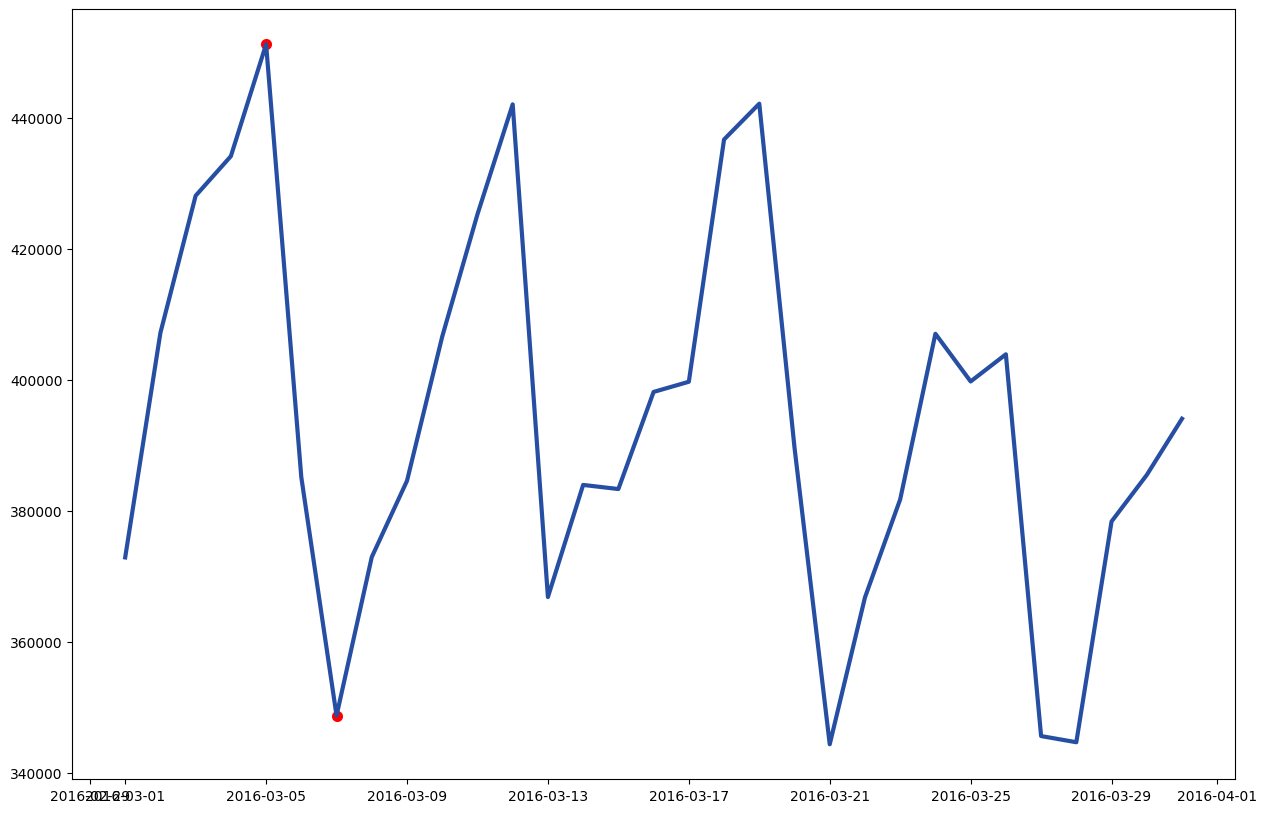

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphe3e5yrk/rr4r_l78.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphe3e5yrk/kykj2r4k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32979', 'data', 'file=/tmp/tmphe3e5yrk/rr4r_l78.json', 'init=/tmp/tmphe3e5yrk/kykj2r4k.json', 'output', 'file=/tmp/tmphe3e5yrk/prophet_modelim8zx8fm/prophet_model-20230421164236.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:42:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:42:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

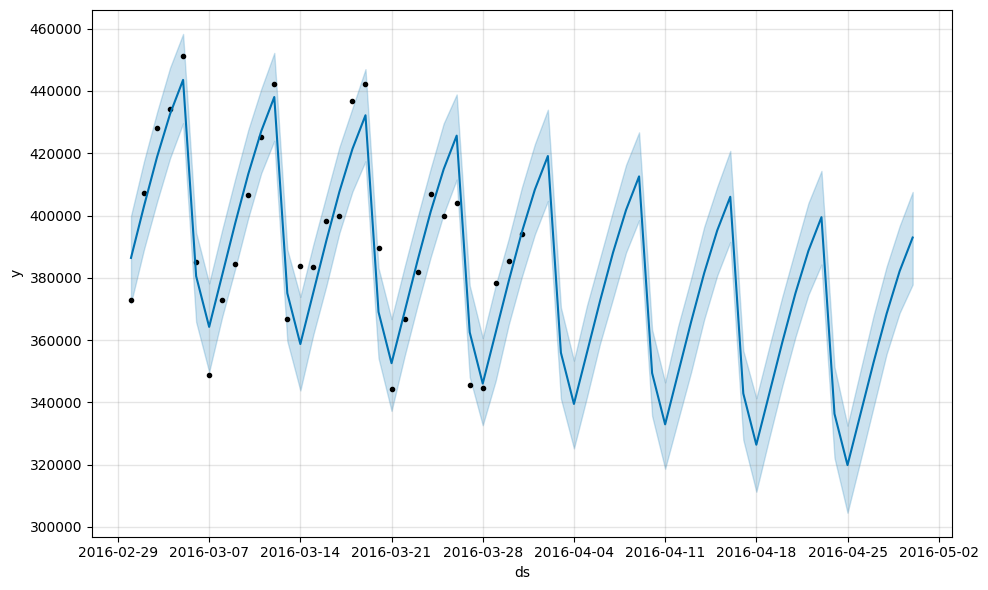

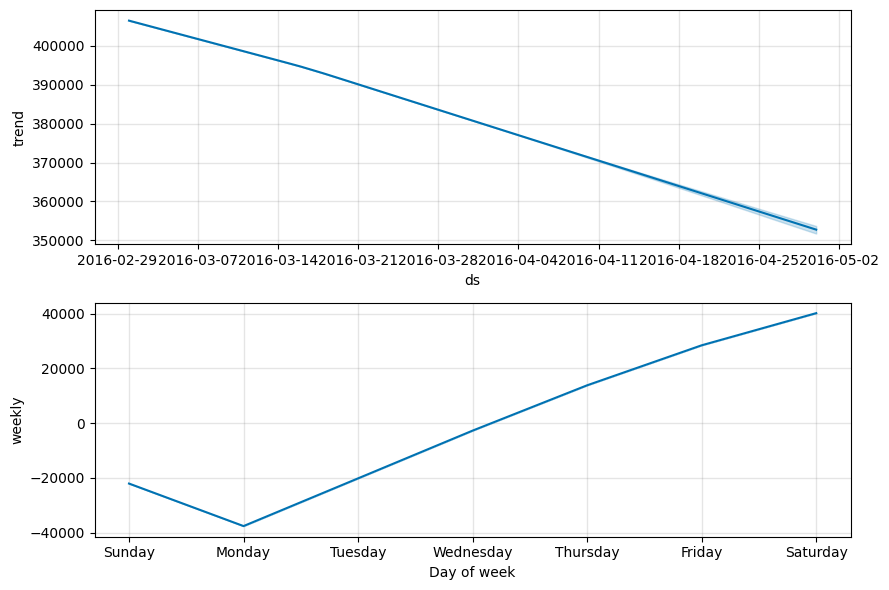


 
 The MAE for the model is 9339.957058500078
The MAPE for the model is 0.024012342431411014 
 



(           ds       y  day_anomaly
 0  2016-03-01  372868            1
 1  2016-03-02  407187            1
 2  2016-03-03  428124            1
 3  2016-03-04  434165            1
 4  2016-03-05  451262           -1
 5  2016-03-06  385103            1
 6  2016-03-07  348700           -1
 7  2016-03-08  372923            1
 8  2016-03-09  384571            1
 9  2016-03-10  406611            1
 10 2016-03-11  425288            1
 11 2016-03-12  442084            1
 12 2016-03-13  366816            1
 13 2016-03-14  383944            1
 14 2016-03-15  383315            1
 15 2016-03-16  398150            1
 16 2016-03-17  399704            1
 17 2016-03-18  436716            1
 18 2016-03-19  442185            1
 19 2016-03-20  389644            1
 20 2016-03-21  344322            1
 21 2016-03-22  366751            1
 22 2016-03-23  381739            1
 23 2016-03-24  407035            1
 24 2016-03-25  399751            1
 25 2016-03-26  403899            1
 26 2016-03-27  345577      

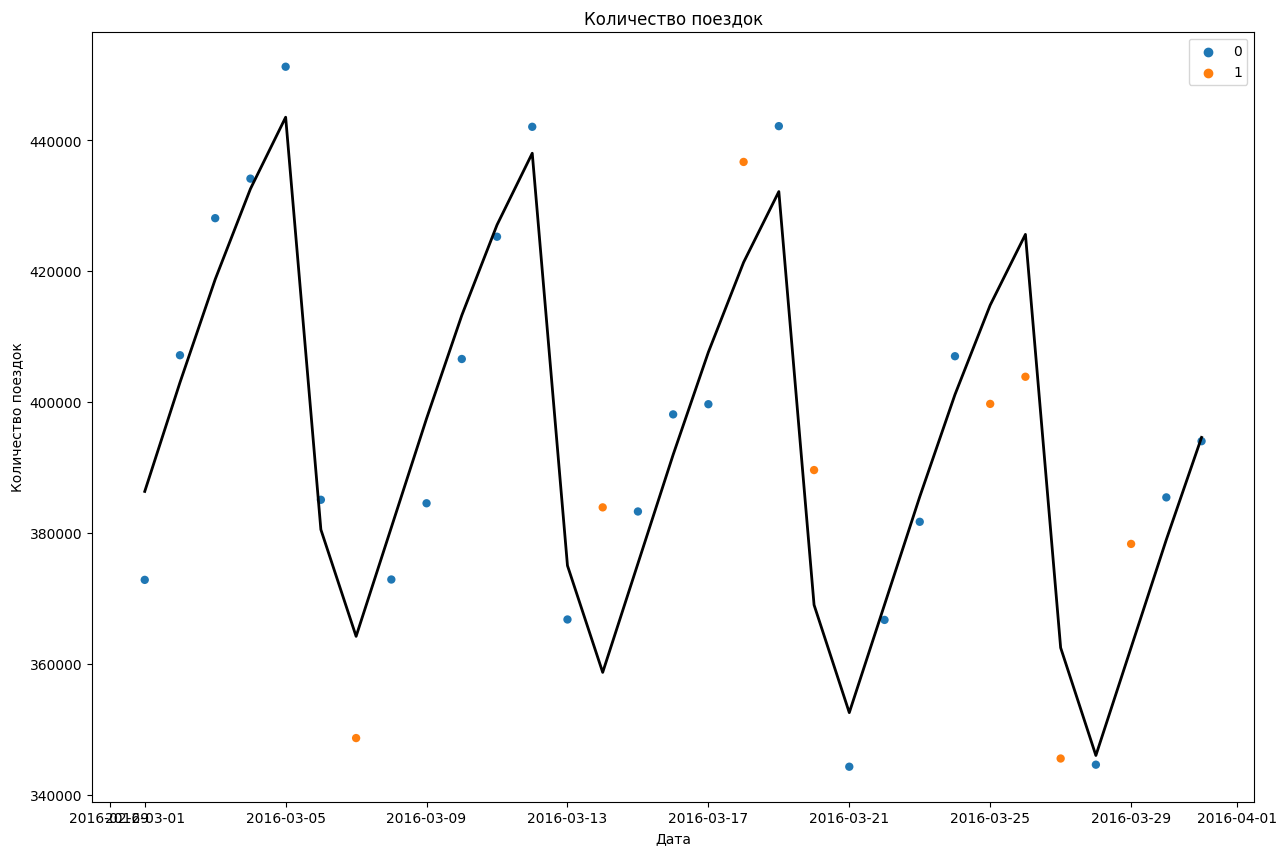

In [14]:

Catch_Anomalies(trip_duration,search_geo_anomalies=False, show_small_geo_map=False)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


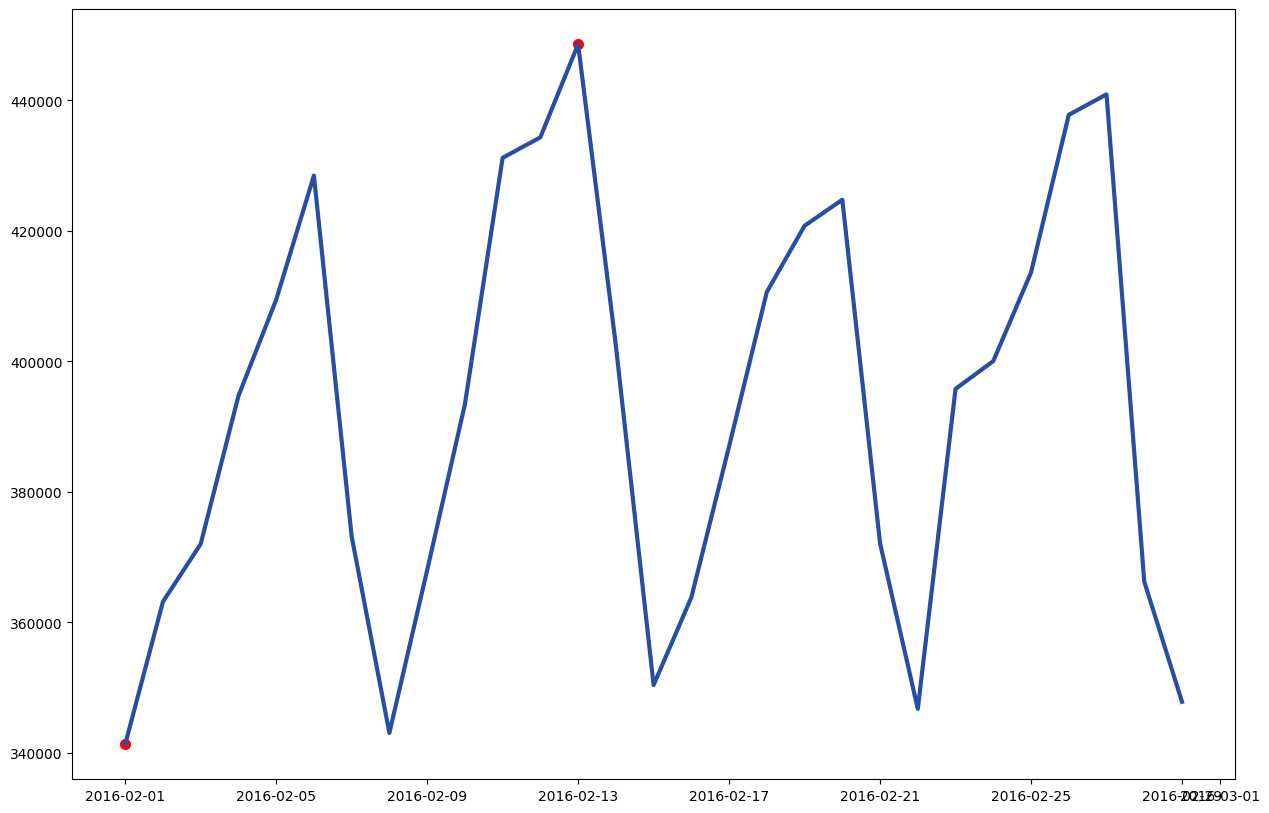

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphe3e5yrk/hilniphm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphe3e5yrk/j46_1m95.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75098', 'data', 'file=/tmp/tmphe3e5yrk/hilniphm.json', 'init=/tmp/tmphe3e5yrk/j46_1m95.json', 'output', 'file=/tmp/tmphe3e5yrk/prophet_model8ik9_ja2/prophet_model-20230421163739.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:37:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:37:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

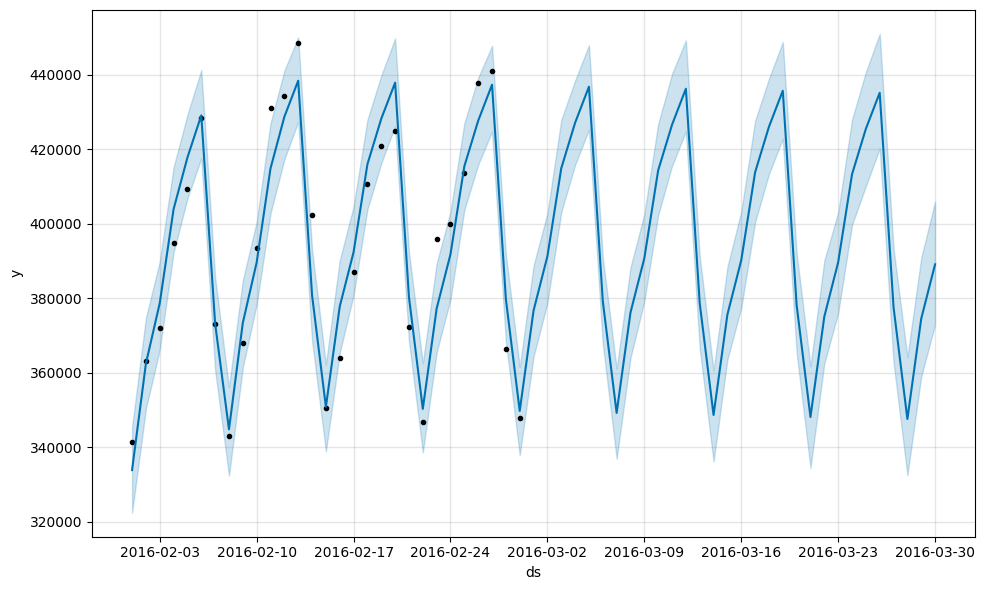

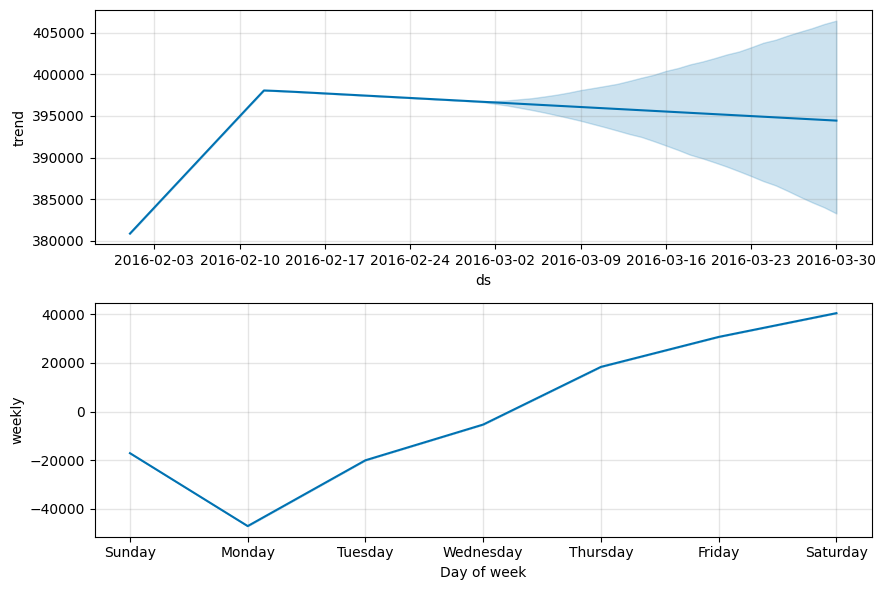


 
 The MAE for the model is 7334.499974928893
The MAPE for the model is 0.018479889685742955 
 



(           ds       y  day_anomaly
 0  2016-02-01  341323           -1
 1  2016-02-02  363162            1
 2  2016-02-03  372021            1
 3  2016-02-04  394699            1
 4  2016-02-05  409453            1
 5  2016-02-06  428485            1
 6  2016-02-07  373201            1
 7  2016-02-08  343066            1
 8  2016-02-09  367992            1
 9  2016-02-10  393400            1
 10 2016-02-11  431206            1
 11 2016-02-12  434350            1
 12 2016-02-13  448611           -1
 13 2016-02-14  402448            1
 14 2016-02-15  350399            1
 15 2016-02-16  363836            1
 16 2016-02-17  386982            1
 17 2016-02-18  410641            1
 18 2016-02-19  420796            1
 19 2016-02-20  424783            1
 20 2016-02-21  372128            1
 21 2016-02-22  346756            1
 22 2016-02-23  395790            1
 23 2016-02-24  400055            1
 24 2016-02-25  413644            1
 25 2016-02-26  437798            1
 26 2016-02-27  440935      

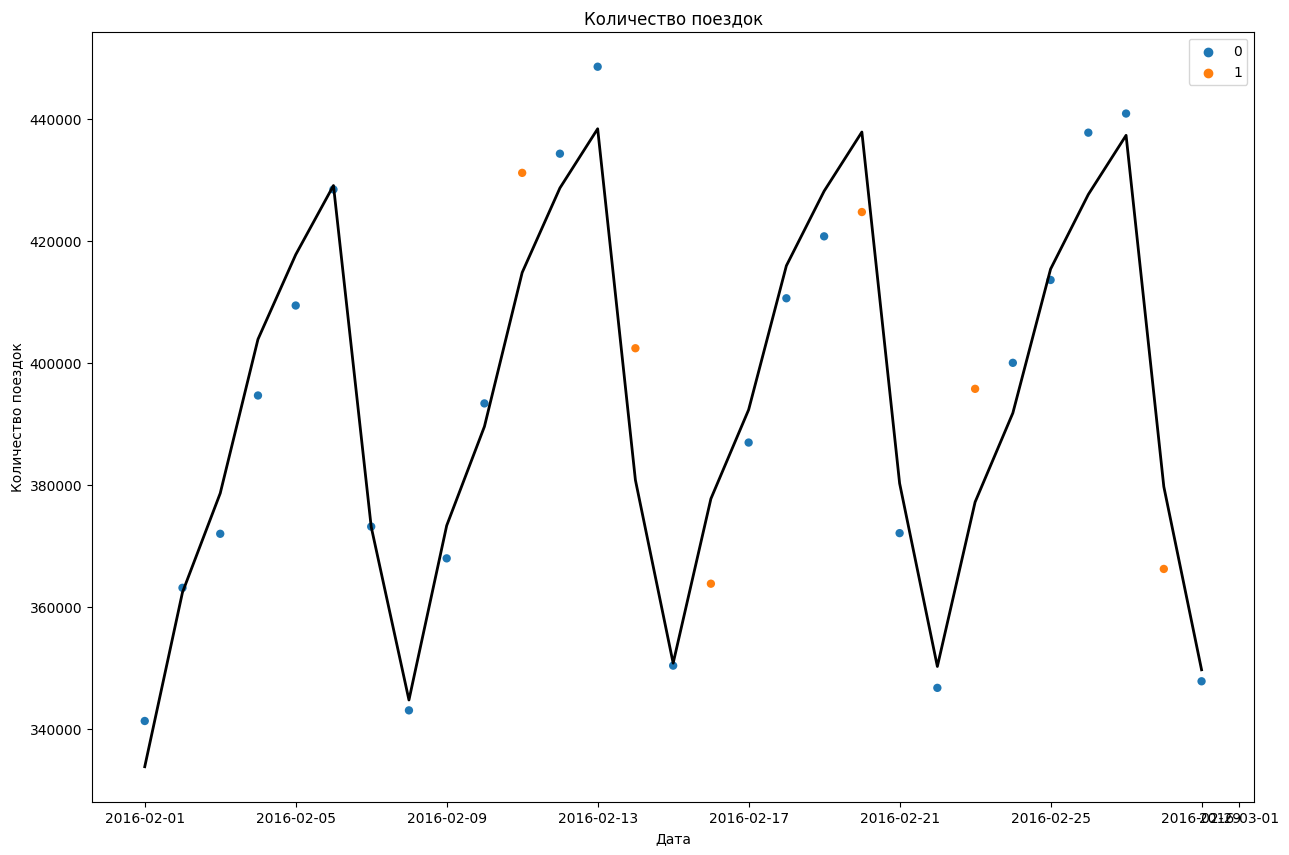

In [11]:
Catch_Anomalies(trip_duration,search_geo_anomalies=False, show_small_geo_map=False)